# How To Guide: How to Add a Damage Sector to MimiGIVE

There are numerous ways to explore and modify the MimiGIVE model. This guide provides suggested workflow for a subset of such modifications, namely those that do not directly modify the MimiGIVE base package itself. Projects with goals that require doing so will have a different advised workflow, using Julia package development workflows. Feel free to post questions to the [Mimi forum](https://forum.mimiframework.org) for advice and documentation references on these from Mimi users and the package developers. Developers also monitor the MimiGIVE [Issues](https://github.com/rffscghg/MimiGIVE.jl/issues) for questions/suggestions.

The **Setup** section below is generic to any new Projects that do not modify the MimiGIVE model source code, as mentioned above. The next sections are specific to the task of adding a new sectoral damages component to the model, but can be used as a template for a variety of other modifications.

This guide does **not** serve as a substitute for or duplicate of the available [Mimi documentation](https://www.mimiframework.org/Mimi.jl/stable/) but instead complements it and may frequently reference Mimi vocabulary and documentation. For example, [Tutorial 3: Modifying an Existing Model](https://www.mimiframework.org/Mimi.jl/stable/tutorials/tutorial_3/) may be particuarly helpful.

Finally, in this notebook we save plots to the *outputs* folder and then reload them to display in order to reduce file size of this notebook. This extra step is not necessary for general use, you may simply display your plot ie. `df |> @vlplot(...)` or `Mimi.plot(...)`.

## Software

This guide assumes you have downloaded Julia (we recommend using [juliaup](https://github.com/JuliaLang/juliaup) to do so) and are using Github.

## File Structure

**To be clear, after this tutorial your repository will more or less mirror this structure, such that *HowToGuide_AddNewSector/* becomes *YourRepositoryName/*. We do not recommend cloning this repository but starting the following workflow from scratch in your new repository, copying in files only as necessary or desired.**

All files pertaining to this guide reside in *MimiGIVE/docs/HowToGuide_AddNewSector*.  The *Manifest.toml* and *Project.toml* files define the environment, as described in the **Setup** section. The *src* subfolder holds all source code. Within this subfolder:
- *main.jl* demonstrates using all functionality described in this guide
- *new_sector_damages.jl* and *main_model.jl* are described in the **Adding Damage Sector to the Model and Computing the SCC** section
- *mcs.jl* and *scc.jl* are described in the **Advanced Topics: Uncertainty and Intermediate Outputs** section

## Setup

First, you will need to set up a Julia Project for your work. Start with a new Github repository, we will use the `HowToGuide_AddNewSector` folder enclosing this guide as the template for that folder.  **Instead of `HowToGuide_AddNewSector`, you will carry out these steps from `YourRepositoryName` folder.** After starting Julia, make the repository folder your current directory and then enter the `Pkg` REPL by typing the `]` key, or alternatively do so using the `Pkg` package as we do below.  Next, activate a new Julia environment, tracked by the `Manifest.toml` and `Project.toml` files (these will appear after you run `add` below), in the current folder.

In [2]:
# These steps simply cd this notebook's code to the folder the guide is in, you 
# can likely skip this step, just make sure your current directory is the top level
# of your repository

# @__DIR__ is a macro that copies the full path name of the current file
println("We will cd to $(@__DIR__)")
cd(joinpath(@__DIR__)) 

# using Pkg
Pkg.activate(".") # activates the environment in the current directory
Pkg.instantiate();

We will cd to /Users/lisarennels/.julia/dev/MimiGIVE/docs/HowToGuide_AddNewSector


Next add `MimiGIVE` to the environment, as well as the `Mimi` package. You will likely also want to add other packages you need as you go along, as we do here with `DataFrames`, `Query`, and `VegaLite` which we use in this notebook for exploration of results. **Note you only need to do this once per repository**, the packages and their versions will be added and tracked, defining your environment via the `Manifest.toml` and `Project.toml` files, though you'll need to keep them updated with commands like `up` as detailed in [Julia documentation on version control and packages](https://pkgdocs.julialang.org/v1/managing-packages/).  Again you can use `]` to open the `Pkg` REPL in your terminal.

In [1]:
Pkg.add("MimiGIVE")
Pkg.add("Mimi")
Pkg.add("DataFrames")
Pkg.add("Query")
Pkg.add("VegaLite")
Pkg.add("Distributions")
Pkg.add("Dates");

The rest of the folder structure is up to you, we will use the customary format of a `src` folder for all soruce code and a `data` folder for exogenous inputs etc.

## Adding Damage Sector to The Model and Computing the SCC

This section will add a new damage sector to the model and link to the computation of the SCC, both deterministically and in Monte Carlo Simulation mode.  The consolidated script can also be found in *HowToGuide_AddNewSector/src/main_model.jl*, which wraps this functionality into a single new function `get_modified_model`, which mirrors `MimiGIVE.get_model`.

### Step 1. Add Component(s) to the Model

In this section, we add a new sectoral damage function to the MimiGIVE model. This is defined in a single Mimi `Component`, although one could use several linked together to carry out a more complex damage function, unit conversions, etc.

First, use the [Mimi documentation](https://www.mimiframework.org/Mimi.jl/stable/tutorials/tutorial_4/) as a guide to create your new component(s).  In this case, we have created component `NewSectorDamages` shown in `new_sector_damages.jl`. **Note that this component is a dummy with no logical form or results, and is meant as an illustrative example**. Load that component along with the MimiGIVE and `Mimi` packages as follows:

In [3]:
using Mimi
using MimiGIVE
include("src/new_sector_damages.jl");

Next we will obtain a Model `m` as defined by MimiGIVE, and then add our new component. The `first` argument shows that our component will start in 2020, as do all damages in MimiGIVE, and it will be added to the model `after` the `energy_damages` component. The order here does matter, as `Variable`s output from components flow into others as `Parameter`s.  For example, our `NewSectorDamages` component needs to come *after* the `temperature` component, but *before* the `DamageAggregator` component.

In [4]:
m = MimiGIVE.get_model()
add_comp!(m, NewSectorDamages, first = 2020, after = :energy_damages);

And connect the relevant parameters from the socioeconomic and temperature components of MimiGIVE to the relevant inputs of our new component:

In [5]:
connect_param!(m, :NewSectorDamages => :temperature, :temperature => :T)
connect_param!(m, :NewSectorDamages => :gdp, :Socioeconomic => :gdp)

You have now added your new component to the model!  You may go ahead and run the model and look at your outputs below, **however** you will see that it's results are _not_ yet added to the aggregated damages, and thus not incorporated into the SCC. We fix these links in the next section and then further explore the results in graphical and tabular form.

In [6]:
run(m)

### Step 2. Add Damages to the Damage Aggregator

The MimiGIVE model uses the `DamageAggregator` component to aggregate damages, and these outputs will be used to calculate the Social Cost of Carbon (SCC) via functions such as `compute_scc`. In this section, we will be using the `Mimi.replace!` function to replace the `DamageAggregator` component with a modified one that includes our new sectoral damages.

In the *HowToGuide_AddNewSector/src/DamageAggregator_NewSectorDamages.jl* we have copied *DamageAggregator.jl* from the MimiGIVE repository, and added lines to include our new sectoral damages. Take a moment to compare the files and see the modifications that were made. Note our code here becomes static, unlinked to the existing *DamageAggregator.jl*, such that if MimiGIVE's version updates, you'll need to update your own by hand to stay in step. First we will load that new component:

In [7]:
include("src/DamageAggregator_NewSectorDamages.jl")

Next we will replace the original `DamageAggregator` component with this new, augmented one using the `Mimi.replace!` function. Note this function by default will assume to find similar structure and connections, and thus maintain existing connections to other components. The `replace!` function will reset the time dimension of the `DamageAggregator` component so you also need reset this component to start in 2020 with `Mimi.set_first_last!` as follows:

In [8]:
replace!(m, :DamageAggregator => DamageAggregator_NewSectorDamages)
Mimi.set_first_last!(m, :DamageAggregator, first=2020); # the DamageAggregator component needs to start in 2020, this is reset to the model start (1765) by replace!, so we need to reset it to 2020

Finally connect the new sectoral damages component to the new damage aggregator.

In [9]:
connect_param!(m, :DamageAggregator => :damage_new_sector, :NewSectorDamages => :damages)

You can now run your model.

In [10]:
run(m)

Build in `Mimi` functions like `explore` and `plot` allow interactive UI exploration and creation of a static plot.  The `explore` function doesn't work well in the notebook interface, so it is commented out, but try it yourself locally! 

In [30]:
# run locally to see the UI for exploring model

# explore(m)

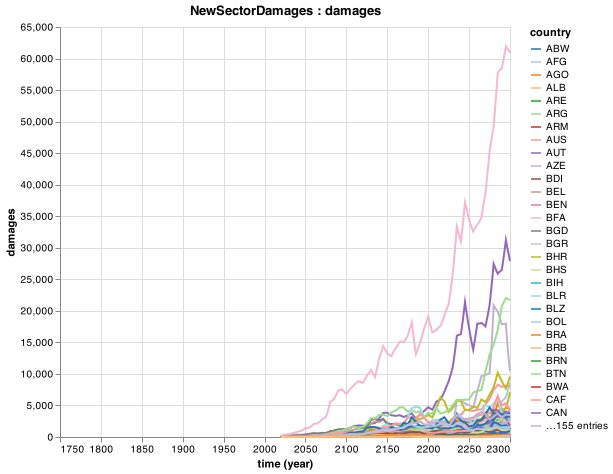

In [13]:
figure_dir = joinpath(@__DIR__, "output", "figures")
ispath(figure_dir) || mkpath(figure_dir)
Mimi.plot(m, :NewSectorDamages, :damages) |> save(joinpath(figure_dir, "NewSector_Damages_v1.png"));
display("image/png", read(joinpath(figure_dir, "NewSector_Damages_v1.png")))

Or look at the data in a tabular format and optionally plot it yourself:

In [14]:
using DataFrames
using Query

df = getdataframe(m, :NewSectorDamages, :damages) |> @filter(_.time >= 2020) |> DataFrame

,time,country,damages
,Int64,String,Float64?
1,2020,ABW,0.0377476
2,2020,AFG,0.558741
3,2020,AGO,1.12083
4,2020,ALB,0.258472
5,2020,ARE,4.22053
6,2020,ARG,9.85914
7,2020,ARM,0.325231
8,2020,AUS,16.2582
9,2020,AUT,5.13239


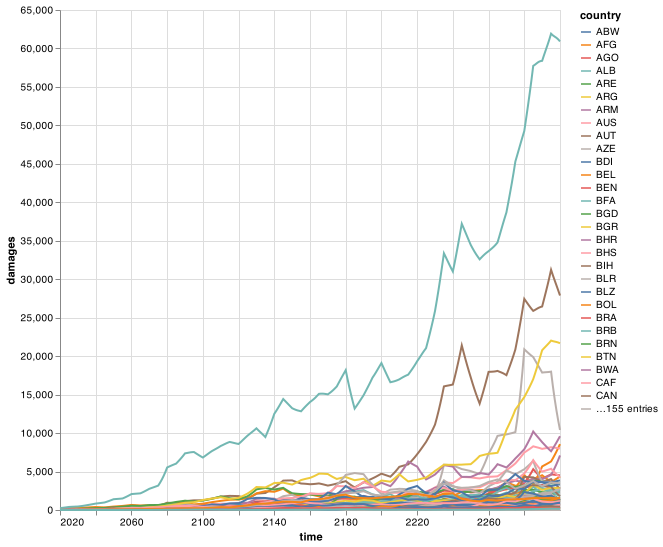

In [32]:
using VegaLite

figure_dir = joinpath(@__DIR__, "output", "figures")
ispath(figure_dir) || mkpath(figure_dir)

df.time = string.(df.time) # convert column to String for plotting
df |> @vlplot(:line, x = "time:t", y = :damages, color = :country, width = 500, height = 500) |> save(joinpath(figure_dir, "NewSector_Damages_v2.png"))
display("image/png", read(joinpath(figure_dir, "NewSector_Damages_v2.png")))

In [16]:
# Compare a determinstic run of the SCC (note in practice MimiGIVE should always be run in Monte Carlo Simulation mode, as the deterministic default is not considered a central value)
println("-- Comparing the SCC results of a deterministic run of the modified model to original GIVE -- \n")

my_scc = MimiGIVE.compute_scc(m, year = 2020)
println("My new SCC is $(my_scc) \n")

m_give = MimiGIVE.get_model()
give_scc = MimiGIVE.compute_scc(m_give, year = 2020)
println("GIVE SCC is $(give_scc) \n")

-- Comparing the SCC results of a deterministic run of the modified model to original GIVE -- 



My new SCC is 88.72719841970478 



GIVE SCC is 26.17480752684712 



In [17]:
# Compare a Monte Carlo run with n = 5
println("-- Comparing the SCC results of a Monte Carlo Simulation (n = 5) run of the modified model to original GIVE --\n")

my_scc_mcs = MimiGIVE.compute_scc(m, year = 2020, n = 5, discount_rates = [(label = "DICE discount rate", prtp = 0.015, eta = 1.45)]);
println("My new SCC results are $(my_scc_mcs[:scc][(region = :globe, sector = :total, dr_label = "DICE discount rate", prtp = 0.015, eta = 1.45)])")

give_scc_mcs = MimiGIVE.compute_scc(m_give, year = 2020, n = 5, discount_rates = [(label = "DICE discount rate", prtp = 0.015, eta = 1.45)]);
println("GIVE SCC results are $(give_scc_mcs[:scc][(region = :globe, sector = :total, dr_label = "DICE discount rate", prtp = 0.015, eta = 1.45)])")


-- Comparing the SCC results of a Monte Carlo Simulation (n = 5) run of the modified model to original GIVE --



Running 5 trials for 1 scenarios...  40%|██████▍         |  ETA: 0:00:07

Running 5 trials for 1 scenarios...  60%|█████████▋      |  ETA: 0:00:05

Running 5 trials for 1 scenarios...  80%|████████████▊   |  ETA: 0:00:03

Running 5 trials for 1 scenarios... 100%|████████████████| Time: 0:00:13


My new SCC results are (expected_scc = 92.03451274996175, se_expected_scc = 16.02884552991066, sccs = [100.01113150720234, 55.229383617957296, 65.35017940131588, 146.87729878094325, 92.70457044239])


Running 5 trials for 1 scenarios...  40%|██████▍         |  ETA: 0:00:04

Running 5 trials for 1 scenarios...  60%|█████████▋      |  ETA: 0:00:04

Running 5 trials for 1 scenarios...  80%|████████████▊   |  ETA: 0:00:02

Running 5 trials for 1 scenarios... 100%|████████████████| Time: 0:00:11


GIVE SCC results are (expected_scc = 49.62561888082814, se_expected_scc = 4.294836186214339, sccs = [41.43436916869327, 44.20249959340306, 44.756387845180896, 52.627450282049686, 65.10738751481377])


The work of this section is consolidated into the `get_modified_model` function in *HowToGuide_AddNewSector/src/main_model.jl* which mirrors `MimiGIVE.get_model`.  We will use this function in the following section.

In [18]:
include("src/main_model.jl")
m = get_modified_model();

## Advanced Topic: Uncertainty and Intermediate Outputs

The steps in the sections above incoporate a new damages sector into MimiGIVE, and into the results of a call to `compute_scc`.  While these changes **will** be reflected in a call to `compute_scc` with an `n > 1` ie. a Monte Carlo Simulation mode, you may wish to (1) add uncertainty to your new damage function or (2) augment the existing optional, grandular outputs of MimiGIVE with yoru new damages.

Here we discuss how to implement these two tasks, noting that these tasks **require** a user to study and understanding of the helper functions within MimiGIVE, and are fairly manual.  Users should feel free to examine the implementations in *MimiGIVE/src/main_mcs.jl* and *MimiGIVE/src/scc.jl* and carry out their own steps instead of following those below ... which are just one example of how this can be accomplished. As mentioned above, any actions that include copy-paste-modify workflows instead of calls like `MimiGIVE.get_mcs` unlink from the current MimiGIVE repository, so any changes made there will need to be manually updated, as opposed to expecting updating your environment with `up` to bring changes in.

Remember, any helper function not exlicitly exported from `MimiGIVE` can be accessed via `MimiGIVE.<function_name>`.

Load in the `get_modified_model` function we wrote in the previous section:

In [19]:
include("src/main_model.jl")

get_modified_model (generic function with 1 method)

##### Creating a Monte Carlo Simulation Definition

In MimiGIVE, the function `MimiGIVE.get_mcs` returns a Monte Carlo Simulation struct of type `Mimi.SimulationDef`.  If we wish to add more random variables to this simulation definition, we can create a new function as follows (and is held in *HowToGuide_AddNewSector/src/mcs.jl*). For details and explanations of Mimi's Monte Carlo Simulation functionality, take a look at the Mimi [Tutorial 5: Monte Carlo Simulations and Sensitivity Analysis Support](https://www.mimiframework.org/Mimi.jl/stable/tutorials/tutorial_5/) and [How To Guide 3: Conduct Monte Carlo Simulations and Sensitivity Analysis](https://www.mimiframework.org/Mimi.jl/stable/howto/howto_3/).

In [20]:
using Distributions

function get_modified_mcs(trials; args...)
    mcs = MimiGIVE.get_mcs(trials; args...) # get the original MCS

    # add new sector uncertainty
    Mimi.add_RV!(mcs, :rv_new_sector_a, Normal(0.005, 0.005/2)) # add random variable
    Mimi.add_transform!(mcs, :NewSectorDamages, :a, :(=), :rv_new_sector_a) # connect random variable to parameter

    return mcs
end

get_modified_mcs (generic function with 1 method)

Next we will add a modified version of MimiGIVEs `run_mcs` function, also copied in *HowToGuide_AddNewSector/src/mcs.jl*). Note that this function uses the one we defined in *main_model.jl*, `get_modified_model.jl`, and the one defined above, `get_modified_mcs`.

In [33]:
using Dates

function run_modified_mcs(;trials::Int64 = 10000, 
        output_dir::Union{String, Nothing} = nothing, 
        save_trials::Bool = false,
        fair_parameter_set::Symbol = :random,
        fair_parameter_set_ids::Union{Vector{Int}, Nothing} = nothing,
        rffsp_sampling::Symbol = :random,
        rffsp_sampling_ids::Union{Vector{Int}, Nothing} = nothing,
        m::Mimi.Model = get_modified_model(), 
        save_list::Vector = [],
        results_in_memory::Bool = true,
    )

    m = deepcopy(m) # in the case that an `m` was provided, be careful that we don't modify the original

    trials < 2 && error("Must run `run_mcs` function with a `trials` argument greater than 1 due to a Mimi specification about SampleStores.  TO BE FIXED SOON!")

    # Set up output directories
    output_dir = output_dir === nothing ? joinpath(@__DIR__, "../output/mcs/", "MCS $(Dates.format(now(), "yyyy-mm-dd HH-MM-SS")) MC$trials") : output_dir
    isdir("$output_dir/results") || mkpath("$output_dir/results")

    trials_output_filename = save_trials ?  joinpath("$output_dir/trials.csv") : nothing

    socioeconomics_module = MimiGIVE._get_module_name(m, :Socioeconomic)
    if socioeconomics_module == :MimiSSPs
    socioeconomics_source = :SSP
    elseif socioeconomics_module == :MimiRFFSPs
    socioeconomics_source = :RFF
    end

    # Get an instance of the mcs
    mcs = get_modified_mcs(trials; 
        socioeconomics_source = socioeconomics_source, 
        mcs_years = Mimi.time_labels(m), 
        fair_parameter_set = fair_parameter_set, 
        fair_parameter_set_ids = fair_parameter_set_ids,
        rffsp_sampling = rffsp_sampling,
        rffsp_sampling_ids = rffsp_sampling_ids,
        save_list = save_list,
    )

    # run monte carlo trials
    results = run(mcs,
        m, 
        trials; 
        trials_output_filename = trials_output_filename, 
        results_output_dir = "$output_dir/results", 
        results_in_memory = results_in_memory
    )

    return results
end

run_modified_mcs (generic function with 1 method)

Now, as long as you have also loaded your `get_modified_model` function from *main_model.jl*, you can run a Monte Carlo Simulation including your new uncertainty! All optional arguments are detailed in the MimiGIVE documentation, below we will save a few intermediate outputs with the `save_list` argument, including the `new_sector_damage` from the `DamageAggregator` component you recently added.

In [34]:
# Run a Monte Carlo Simulation
save_list = [
    (:DamageAggregator, :total_damage),
    (:DamageAggregator, :total_damage_share),
    (:DamageAggregator, :cromar_mortality_damage),
    (:DamageAggregator, :agriculture_damage),
    (:DamageAggregator, :energy_damage),
    (:DamageAggregator, :new_sector_damage),
    (:global_netconsumption, :net_consumption),
    (:global_netconsumption, :net_cpc),
    (:global_netconsumption, :global_gdp),
    (:global_netconsumption, :global_population),
    (:temperature, :T),
    (:glaciers_small_icecaps, :gsic_sea_level) ,
    (:antarctic_icesheet, :ais_sea_level),
    (:greenland_icesheet, :greenland_sea_level),
    (:thermal_expansion, :te_sea_level),
    (:landwater_storage, :lws_sea_level)
]

output_dir = joinpath(@__DIR__, "output", "mcs", "MCS_main_output")
mkpath(output_dir)
results = run_modified_mcs(trials=10, save_list=save_list, output_dir=output_dir);
println() # prevent overflow of notebook text

Results can now be examined in the `results` returned to memory graphically (again `explore` does not work well in a notebook interface but try it yourself locally), and the tabular outputs are also stored in the *HowToGuide_AddNewSector/output/mcs* folder. **Importantly, these files can get VERY large for country-specific variables at high `n` values (on the order of GB for `n = 1000`, so we recommend being careful with what you save when running high numbers of trials)**. In most cases you will not want to run `run_modified_mcs` on it's own, but instead wrap it into the SCC calculation as below.

In [ ]:
# run locally to see the UI for exploring MCS, although note with large number 
# of trials performance can slow for this UI

# explore(simulation) 

In [23]:
using DataFrames
using Query

df = getdataframe(results, :DamageAggregator, :new_sector_damage) |> @filter(_.time >= 2020) |> DataFrame

,time,new_sector_damage,trialnum
,Int64,Float64?,Int64
1,2020,1.67946e12,1
2,2021,1.80548e12,1
3,2022,1.94201e12,1
4,2023,2.08792e12,1
5,2024,2.2403e12,1
6,2025,2.39453e12,1
7,2026,2.56116e12,1
8,2027,2.73143e12,1
9,2028,2.91022e12,1


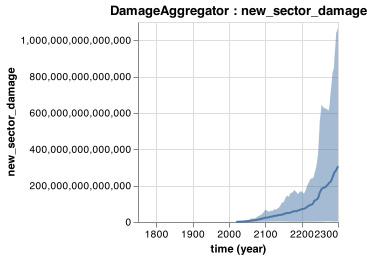

In [24]:
figure_dir = joinpath(@__DIR__, "output", "figures")
ispath(figure_dir) || mkpath(figure_dir)

Mimi.plot(results, :DamageAggregator, :new_sector_damage) |> save(joinpath(figure_dir, "NewSector_MCS_Damages.png"))
display("image/png", read(joinpath(figure_dir, "NewSector_MCS_Damages.png")))

##### Linking to the Intermediate Monte Carlo SCC Outputs

A final step is to (1) compute a Monte Carlo Simulation mode SCC that incorporates our new uncertainty and (2) incorporate our new damage function into the intermediate outputs of the existing SCC computation function, controlled my optional arguments in the `MimiGIVE.compute_scc` function, to allow for viewing disaggregated results. Here we carry this out by starting from the three functions in MimiGIVE's `scc.jl` file, copying them, and modifying them to produce the three functions in *HowToGuide_AddNewSector/src/scc.jl*.  For sake of space we do not copy these below, but please view them in that file.  

**Note** once again that this copy and paste method unlinks from current MimiGIVE, and cannot track changes in the original functions. Also, this is again just one approach, users should feel free to write their own new versions of these functions etc. to suit their needs.

We create three new functions:

- `compute_modified_scc`
- `modified_most_trial_func`
- `_compute_modified_scc_mcs`

After importing those three functions, you will be abel to use the `compute_modified_scc` function, along with all of the optional args described in the original `MimiGIVE.compute_scc` function documentation, to produce SCC values and intermediate outputs.

In [25]:
include("src/scc.jl")

output_dir = joinpath(@__DIR__, "output", "scc", "SCC_main_output")
mkpath(output_dir)

results = compute_modified_scc(
                year=2020, 
                n=10, 
                discount_rates = [(label = "DICE discount rate", prtp = 0.015, eta = 1.45), (label = "2.0%", prtp = exp(0.001972641) - 1, eta = 1.244458999)],
                output_dir=output_dir, 
                save_list=save_list,
                compute_sectoral_values = true,
                save_md = true
            );

Running 10 trials for 1 scenarios...  20%|███            |  ETA: 0:00:13

Running 10 trials for 1 scenarios...  30%|████▌          |  ETA: 0:00:15

Running 10 trials for 1 scenarios...  40%|██████         |  ETA: 0:00:14

Running 10 trials for 1 scenarios...  50%|███████▌       |  ETA: 0:00:12

Running 10 trials for 1 scenarios...  60%|█████████      |  ETA: 0:00:10

Running 10 trials for 1 scenarios...  70%|██████████▌    |  ETA: 0:00:08

Running 10 trials for 1 scenarios...  80%|████████████   |  ETA: 0:00:05

Running 10 trials for 1 scenarios...  90%|█████████████▌ |  ETA: 0:00:03

Running 10 trials for 1 scenarios... 100%|███████████████| Time: 0:00:26


Note that the `results` returned is a fairly complex data structure, described in the MimiGIVE documentation and accessed within the MimiGIVE paper replication code, but if you have trouble accessing values please open an [Issue](https://github.com/rffscghg/MimiGIVE.jl/issues) to get in touch with the developers!

Also take a look at the output directory in *HowToGuide_AddNewSector*, which holds intermediate results for the `save_list` variables, with the base (no pulse) model as *model_1* and the modified (with pulse) model as *model_2*.  **Importantly, these files can get VERY large for country-specific variables at high `n` values (on the order of GB for `n = 1000`, so we recommend being careful with what you save when running high numbers of trials)**.

In [26]:
using DataFrames
using Query

In [27]:
# Access the computed SCC values

scc_df = DataFrame(:region => [], :sector => [], :discount_rate_label => [], :expected_scc => [], :se_expected_scc => [])

results_scc = results[:scc] # results is a dictionary, :scc is a key to this dictionary
for (k,v) in results_scc 
    # results_scc is a dictionary, we iterate over it's keys (k) and values (v)
    # --- the keys are each a NamedTuple with elements region, sector, dr_label, prtp, and eta
    # --- the values are each a Named Tuple with elements expected_scc, se_expected_scc, and sccs (a vector of the sccs)
    append!(scc_df, DataFrame(
                        :region => k.region, 
                        :sector => k.sector, 
                        :discount_rate_label => k.dr_label, 
                        :expected_scc => v[:expected_scc], 
                        :se_expected_scc => v[:se_expected_scc]
                    )
    )
end

scc_df

,region,sector,discount_rate_label,expected_scc,se_expected_scc
,Any,Any,Any,Any,Any
1,globe,new_sector,2.0%,188.137,45.1694
2,globe,new_sector,DICE discount rate,49.1647,12.1762
3,globe,energy,2.0%,6.52869,0.721222
4,globe,agriculture,2.0%,75.6265,19.8148
5,globe,total,2.0%,342.268,54.7026
6,globe,agriculture,DICE discount rate,22.2703,8.43041
7,globe,total,DICE discount rate,93.4382,17.8306
8,globe,cromar_mortality,2.0%,70.2519,8.39636
9,globe,slr,2.0%,1.7244,0.592293


In [28]:
# Access the marginal damages (undiscounted)

# marginal damages for the global region for sector new_sector
mds = results[:mds][((region = :globe, sector = :new_sector))]
mds_df = DataFrame(mds, :auto)
rename!(mds_df, Symbol.(2020:2300))
insertcols!(mds_df, 1, :trial => 1:10)
mds_df = stack(mds_df, Not(:trial))
rename!(mds_df, [:trial, :time, :value])

,trial,time,value
,Int64,String,Float64
1,1,2020,0.0
2,2,2020,0.0
3,3,2020,0.0
4,4,2020,0.0
5,5,2020,0.0
6,6,2020,0.0
7,7,2020,0.0
8,8,2020,0.0
9,9,2020,0.0


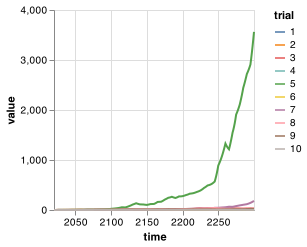

In [29]:
using VegaLite

figure_dir = joinpath(@__DIR__, "output", "figures")
ispath(figure_dir) || mkpath(figure_dir)

mds_df |> @vlplot(:line, x = "time:t", y = :value, color = "trial:n") |> save(joinpath(figure_dir, "NewSector_MCS_MarginalDamages.png"));
display("image/png", read(joinpath(figure_dir, "NewSector_MCS_MarginalDamages.png")))